# VAR models: VAR, VARMA, VARMAX

### Notes

* The VAR model family comprises several varieties:
    * VAR: Vector Autoregressive
    * VARMA: Vector Autoregressive Moving Average
    * VARMAX: Vector Autoregressive Moving Average with Exogenous variables (=features)
* VAR models forecast a group of time series at once by adding autoregressive terms for all series to the regression equation of each series.
* VAR and VARMA are univariate models, whereas VARMAX is a multivariate model which requires forecasted features as inputs for forecasting.
* VAR models require stationary time series.
* Seasonality is usually handled outside of VAR models in a preceding step.

### References

* https://www.statsmodels.org/stable/generated/statsmodels.tsa.statespace.varmax.VARMAX.html
* https://www.statsmodels.org/stable/generated/statsmodels.tsa.statespace.varmax.VARMAXResults

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.varmax import VARMAX

from forecasttk.lineartrend import LinearTrend
import forecasttk.visualize as viz
from forecasttk.evaluate import eval_model 

plt.style.use("seaborn-whitegrid")

## Load and prepare data

In [2]:
# Load data
df = pd.read_csv("data/catalog_seasfac.csv",
                 usecols=["date", "men", "women", "jewel", "mail", "page", "phone", "print", "service"],
                 index_col = "date")

# Convert index to PeriodIndex
df.index = pd.to_datetime(df.index).to_period("M")

In [3]:
# Define features and targets
targets = ["men", "women"]
features = ["mail", "page", "phone", "print", "service"]
Y = df[targets]
X = df[features]

# Show features and target
Y.join(X).head()

,men,women,mail,page,phone,print,service
date,,,,,,,
1989-01,11357.92,16578.93,7978,73,34,22294.48,20
1989-02,10605.95,18236.13,8290,88,29,27426.47,20
1989-03,16998.57,43393.55,8029,65,24,27978.66,26
1989-04,6563.75,30908.49,7752,85,20,28949.65,22
1989-05,6607.69,28701.58,8685,74,17,22642.27,21


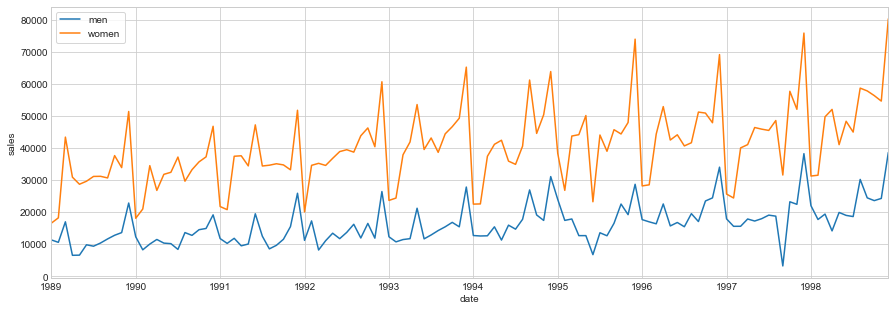

In [4]:
# Visualize targets
viz.plot_series(*[Y[ta] for ta in targets], xlabel=df.index.name, ylabel="sales")

## Making time series stationary: De-trend targets

For the sake of simplicity, the linear trend models for making the time series stationary are fitted on the whole data set here, not just on the training data and then forecasted. In a real case, thee trends would have to be forecasted as well.

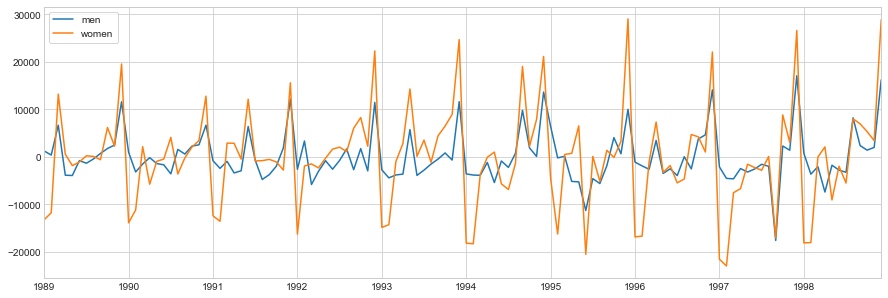

In [5]:
# De-trend targets with LinearTrend
Y_trend = pd.DataFrame(index=Y.index)
Y_dt = pd.DataFrame(index=Y.index)
for target in targets:
    model = LinearTrend(y=Y[target]).fit_ts()
    Y_trend[target] = model.predict_ts()
    Y_dt[target] = (Y[target] - Y_trend[target])
    
# Visualize de-trended features
viz.plot_series(*[Y_dt[t] for t in targets])

## VAR model

In [6]:
# Train/test split
Y_train = Y_dt[:"1997"]
Y_test = Y_dt["1998"]

In [7]:
# Instantiate and train model with AR(2)
model = VARMAX(Y_train, exog=None, order=(2,0))
model = model.fit(maxiter=1000)
model.summary()

Dep. Variable:,"['men', 'women']",No. Observations:,108
Model:,VAR(2),Log Likelihood,-2160.693
,+ intercept,AIC,4347.386
Date:,"Tue, 07 Jan 2020",BIC,4382.254
Time:,13:04:03,HQIC,4361.524
Sample:,01-31-1989,,
,- 12-31-1997,,
Covariance Type:,opg,,
Ljung-Box (Q):,"90.20, 36.82",Jarque-Bera (JB):,"31.85, 1.27"
Prob(Q):,"0.00, 0.61",Prob(JB):,"0.00, 0.53"
Heteroskedasticity (H):,"2.12, 1.51",Skew:,"0.75, 0.07"



>> men
>>>> training set
Mean of true values:          -95.0639
Mean of predicted values:     -135.3782
Mean absolute error:          3546.4613
Mean relative error:          -37.3061
Root mean squared error:      4988.0070
Coefficient of determination: 0.0367
>>>> test set
Mean of true values:          855.5753
Mean of predicted values:     235.0898
Mean absolute error:          4508.5750
Mean relative error:          5.2696
Root mean squared error:      6134.2660
Coefficient of determination: -0.0553

>> women
>>>> training set
Mean of true values:          -19.6089
Mean of predicted values:     65.4360
Mean absolute error:          6875.9285
Mean relative error:          -350.6527
Root mean squared error:      9702.2333
Coefficient of determination: 0.0936
>>>> test set
Mean of true values:          176.4805
Mean of predicted values:     -1175.4498
Mean absolute error:          8049.5246
Mean relative error:          45.6114
Root mean squared error:      10762.1282
Coefficient of de

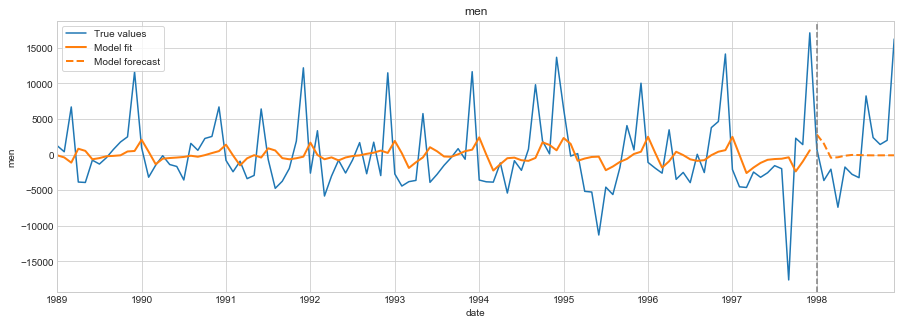

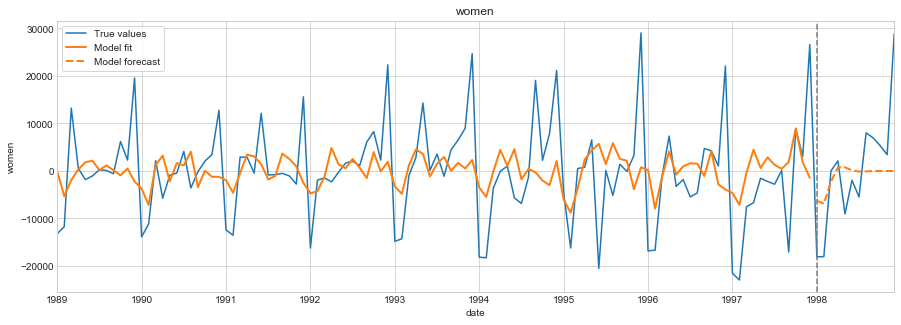

In [8]:
# Predict and forecast
Y_pred = model.predict()
Y_fcst = model.forecast(12)

# Evaluate model on training and test set 
for target in targets:
    print("\n>>", target)
    print(">>>> training set")
    eval_model(Y_train[target], Y_pred[target])
    print(">>>> test set")
    eval_model(Y_test[target], Y_fcst[target])
    
# Visualize fit and forecast
for target in targets:
    viz.plot_model(Y_dt[target], Y_pred[target], Y_fcst[target], 
                 xlabel=Y.index.name, ylabel=target, title=target)

C:\Users\csa\Documents\Data Science\Projects\forecasting-toolkit-github\forecasttk\visualize.py:152: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


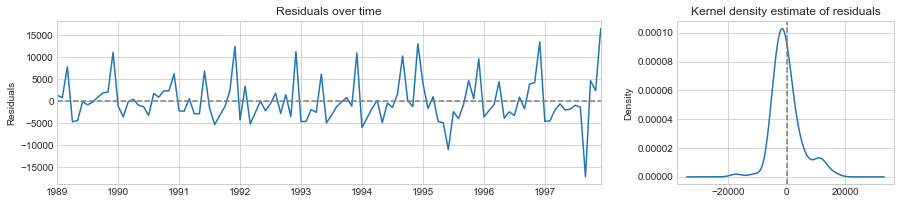

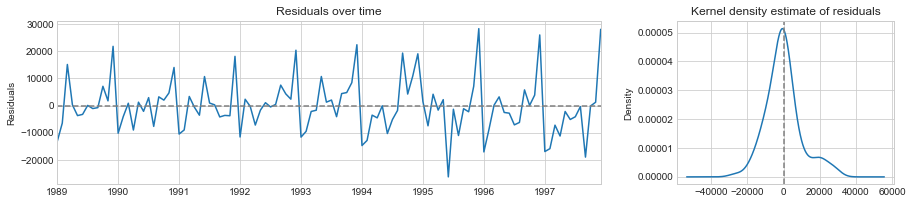

In [9]:
# Plot residuals
residuals = Y_train - Y_pred
for target in targets:
    viz.plot_residuals(residuals[target], figsize=(15,3))

## VARMA model

In [10]:
# Train/test split
Y_train = Y_dt[:"1997"]
Y_test = Y_dt["1998"]

In [11]:
# Instantiate and train model - AR(2) MA(2)
model = VARMAX(Y_train, exog=None, order=(2,2))
model = model.fit(maxiter=500)
model.summary()

C:\Users\csa\anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:159: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)


Dep. Variable:,"['men', 'women']",No. Observations:,108
Model:,"VARMA(2,2)",Log Likelihood,-2147.169
,+ intercept,AIC,4336.337
Date:,"Tue, 07 Jan 2020",BIC,4392.662
Time:,13:04:39,HQIC,4359.175
Sample:,01-31-1989,,
,- 12-31-1997,,
Covariance Type:,opg,,
Ljung-Box (Q):,"60.33, 44.31",Jarque-Bera (JB):,"33.49, 1.53"
Prob(Q):,"0.02, 0.29",Prob(JB):,"0.00, 0.47"
Heteroskedasticity (H):,"1.72, 1.18",Skew:,"0.25, -0.06"


C:\Users\csa\anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:159: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)



>> men
>>>> training set
Mean of true values:          -95.0639
Mean of predicted values:     -301.6884
Mean absolute error:          3230.9988
Mean relative error:          -33.9876
Root mean squared error:      4545.5133
Coefficient of determination: 0.2001
>>>> test set
Mean of true values:          855.5753
Mean of predicted values:     -94.2380
Mean absolute error:          5139.0149
Mean relative error:          6.0065
Root mean squared error:      6562.9388
Coefficient of determination: -0.2080

>> women
>>>> training set
Mean of true values:          -19.6089
Mean of predicted values:     -107.1279
Mean absolute error:          6789.5580
Mean relative error:          -346.2480
Root mean squared error:      9156.2650
Coefficient of determination: 0.1927
>>>> test set
Mean of true values:          176.4805
Mean of predicted values:     -1583.1294
Mean absolute error:          8382.1109
Mean relative error:          47.4960
Root mean squared error:      11210.3426
Coefficient of 

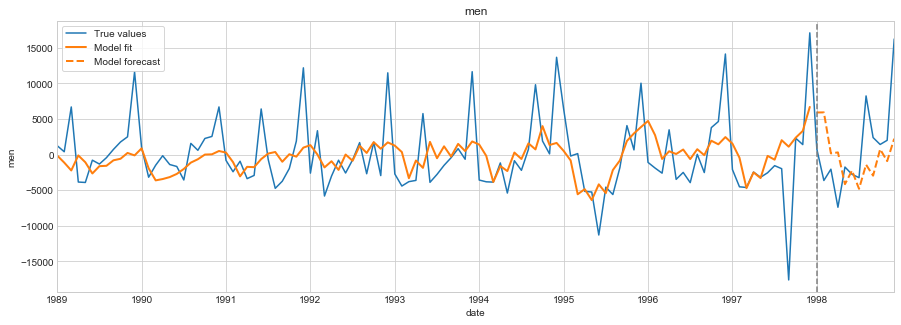

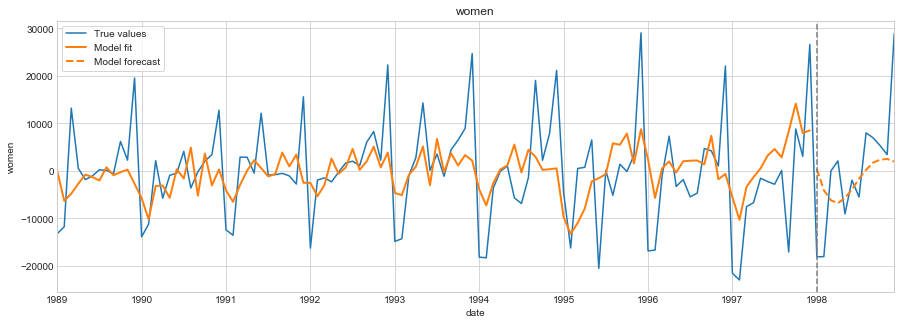

In [12]:
# Predict and forecast
Y_pred = model.predict()
Y_fcst = model.forecast(12)

# Evaluate model on training and test set 
for target in targets:
    print("\n>>", target)
    print(">>>> training set")
    eval_model(Y_train[target], Y_pred[target])
    print(">>>> test set")
    eval_model(Y_test[target], Y_fcst[target])
    
# Visualize fit and forecast
for target in targets:
    viz.plot_model(Y_dt[target], Y_pred[target], Y_fcst[target], 
                 xlabel=Y.index.name, ylabel=target, title=target)

## VARMAX model


### De-trend features with LinearTrend

For the sake of simplicity, the linear trend models for making the time series stationary are again fitted on the whole data set here, not just on the training data. In a real case, linear trends would have to be forecasted as well.

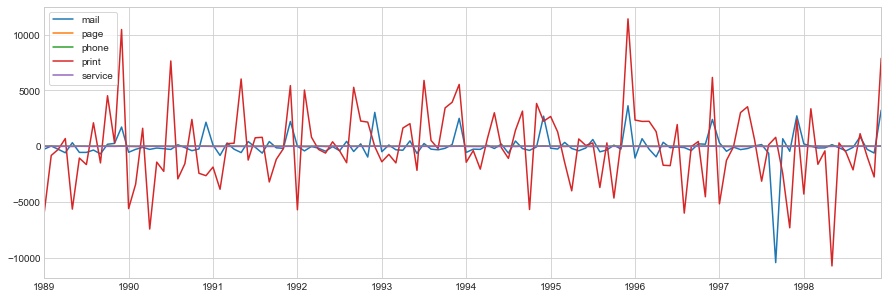

In [13]:
# De-trend features with LinearTrend
X_trend = pd.DataFrame(index=X.index)
X_dt = pd.DataFrame(index=X.index)
for feature in features:
    model = LinearTrend(y=X[feature]).fit_ts()
    X_trend[feature] = model.predict_ts()
    X_dt[feature] = X[feature] - X_trend[feature]
    
# Visualize de-trended features
viz.plot_series(*[X_dt[f] for f in features])

In [14]:
# Train/test split
Y_train = Y_dt[:"1997"]
X_train = X_dt[:"1997"]
Y_test = Y_dt["1998"]
X_test = X_dt["1998"]

In [15]:
# Instantiate and train model - AR(2) MA(0)
model = VARMAX(Y_train, exog=X_train, order=(2,0))
model = model.fit(maxiter=500)
model.summary()

Dep. Variable:,"['men', 'women']",No. Observations:,108
Model:,VARX(2),Log Likelihood,-2046.616
,+ intercept,AIC,4139.233
Date:,"Tue, 07 Jan 2020",BIC,4200.922
Time:,13:04:58,HQIC,4164.245
Sample:,01-31-1989,,
,- 12-31-1997,,
Covariance Type:,opg,,
Ljung-Box (Q):,"62.97, 55.68",Jarque-Bera (JB):,"31.93, 4.16"
Prob(Q):,"0.01, 0.05",Prob(JB):,"0.00, 0.13"
Heteroskedasticity (H):,"1.76, 1.36",Skew:,"0.85, -0.43"



>> men
>>>> training set
Mean of true values:          -95.0639
Mean of predicted values:     -87.2060
Mean absolute error:          1907.4122
Mean relative error:          -20.0645
Root mean squared error:      2551.5872
Coefficient of determination: 0.7479
>>>> test set
Mean of true values:          855.5753
Mean of predicted values:     1191.5238
Mean absolute error:          3264.7241
Mean relative error:          3.8158
Root mean squared error:      3906.6741
Coefficient of determination: 0.5720

>> women
>>>> training set
Mean of true values:          -19.6089
Mean of predicted values:     226.3891
Mean absolute error:          4358.5874
Mean relative error:          -222.2755
Root mean squared error:      5915.2707
Coefficient of determination: 0.6631
>>>> test set
Mean of true values:          176.4805
Mean of predicted values:     -480.4666
Mean absolute error:          4854.7219
Mean relative error:          27.5085
Root mean squared error:      6860.8558
Coefficient of dete

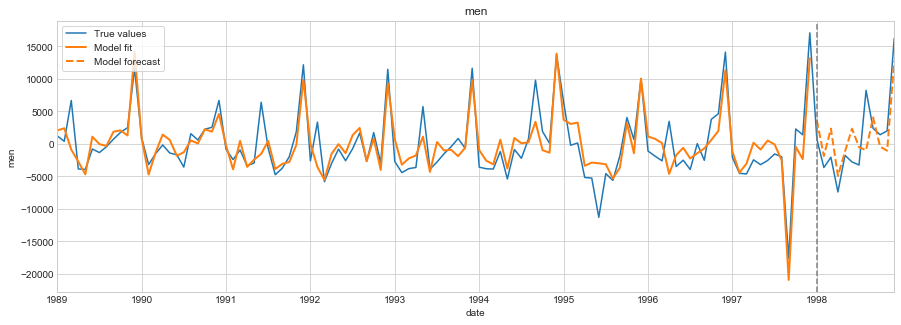

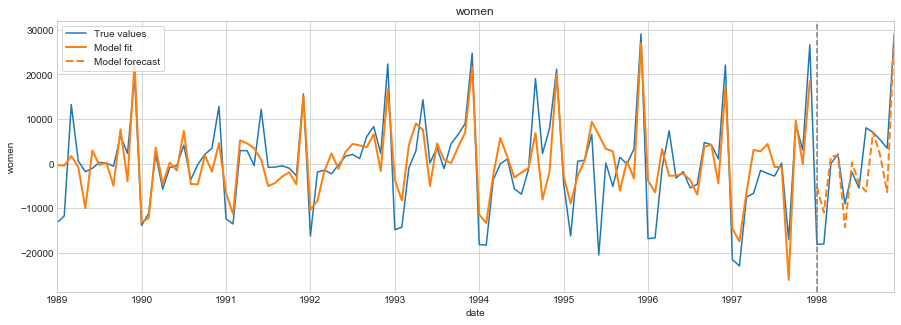

In [16]:
# Predict 
Y_pred = model.predict()

# "Forecast" features using test data
X_fcst = X_test

# Forecast targets
Y_fcst = model.forecast(steps=12, exog=X_fcst)

# Evaluate model on training and test set 
for target in targets:
    print("\n>>", target)
    print(">>>> training set")
    eval_model(Y_train[target], Y_pred[target])
    print(">>>> test set")
    eval_model(Y_test[target], Y_fcst[target])

# Visualize fit and forecast
for target in targets:
    viz.plot_model(Y_dt[target], Y_pred[target], Y_fcst[target], 
                 xlabel=Y.index.name, ylabel=target, title=target)